In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
# from google.colab import drive
import matplotlib.pyplot as plt
from PIL import Image as PILImage
from IPython.display import Image as IPImage
from collections import Counter
import json
import torch
import itertools
from tqdm import tqdm
import torchvision
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import ImageFolder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MultiLabelBinarizer
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.metrics import multilabel_confusion_matrix

In [17]:
import warnings
# to ignore unnecessary warnings in the notebook output
warnings.filterwarnings('ignore')

# setting seed to reproduce the model performance
torch.manual_seed(42)

In [18]:
extracted_files_dir = 'extracted_images\\'
extracted_files = os.listdir(extracted_files_dir)
print(f"Extracted folders and files: {extracted_files}")

Extracted folders and files: ['test_1', 'test_2', 'train_1', 'train_2', 'train_3', 'validation_1', 'validation_2']


#### **Dataset**
The dataset which we have chosen is from Kaggle which is a [Celeb Face Attributes dataset](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset/data), the dataset is annotated with around 40 attributes.



*   202,599 number of face images of various celebrities
*   10,177 unique identities, but names of identities are not given
*   40 binary attribute annotations per image such as Male, Attractiveness, Young etc,.
*   5 landmark locations such as left eye, mouth etc,.

**Data Files:**

list_eval_partition.csv     : Recommended partitioning of images into training, validation, testing sets.

list_bbox_celeba.csv        :  Bounding box information for each image.

list_landmarks_align_celeba.csv: Image landmarks and their respective coordinates.

list_attr_celeba.csv        : Attribute labels for each image. There are 40 attributes. "1" represents positive while "-1" represents negative.


In [19]:
# setting all the folders and files to it's respective variables for using it later on!
eval_partition_file = "list_eval_partition.csv"
bbox_celeb_file = "list_bbox_celeba.csv"
landmarks_celeb_file = "list_landmarks_align_celeba.csv"
attr_celebs_file = "list_attr_celeba.csv"

celeb_imgs_file = "extracted_images\\"

In [20]:
# reading celeb face attributes file
celeb_attr = pd.read_csv(attr_celebs_file)
new_column_names = [col.replace('_', ' ') if col != 'image_id' else col for col in celeb_attr.columns]
celeb_attr.columns = new_column_names
celeb_attr.head()

,image_id,5 o Clock Shadow,Arched Eyebrows,Attractive,Bags Under Eyes,Bald,Bangs,Big Lips,Big Nose,Black Hair,...,Sideburns,Smiling,Straight Hair,Wavy Hair,Wearing Earrings,Wearing Hat,Wearing Lipstick,Wearing Necklace,Wearing Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [21]:
celeb_attr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202599 entries, 0 to 202598
Data columns (total 41 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   image_id             202599 non-null  object
 1   5 o Clock Shadow     202599 non-null  int64 
 2   Arched Eyebrows      202599 non-null  int64 
 3   Attractive           202599 non-null  int64 
 4   Bags Under Eyes      202599 non-null  int64 
 5   Bald                 202599 non-null  int64 
 6   Bangs                202599 non-null  int64 
 7   Big Lips             202599 non-null  int64 
 8   Big Nose             202599 non-null  int64 
 9   Black Hair           202599 non-null  int64 
 10  Blond Hair           202599 non-null  int64 
 11  Blurry               202599 non-null  int64 
 12  Brown Hair           202599 non-null  int64 
 13  Bushy Eyebrows       202599 non-null  int64 
 14  Chubby               202599 non-null  int64 
 15  Double Chin          202599 non-nu

In [22]:
#print(celeb_attr.isnull().any())

In [23]:
# reading evaluation partion file
eval_partition = pd.read_csv(eval_partition_file)
eval_partition.head()

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


In [24]:
# reading landmark align celeb file
landmarks_celeb = pd.read_csv(landmarks_celeb_file)
landmarks_celeb.head()

,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
0,000001.jpg,69,109,106,113,77,142,73,152,108,154
1,000002.jpg,69,110,107,112,81,135,70,151,108,153
2,000003.jpg,76,112,104,106,108,128,74,156,98,158
3,000004.jpg,72,113,108,108,101,138,71,155,101,151
4,000005.jpg,66,114,112,112,86,119,71,147,104,150


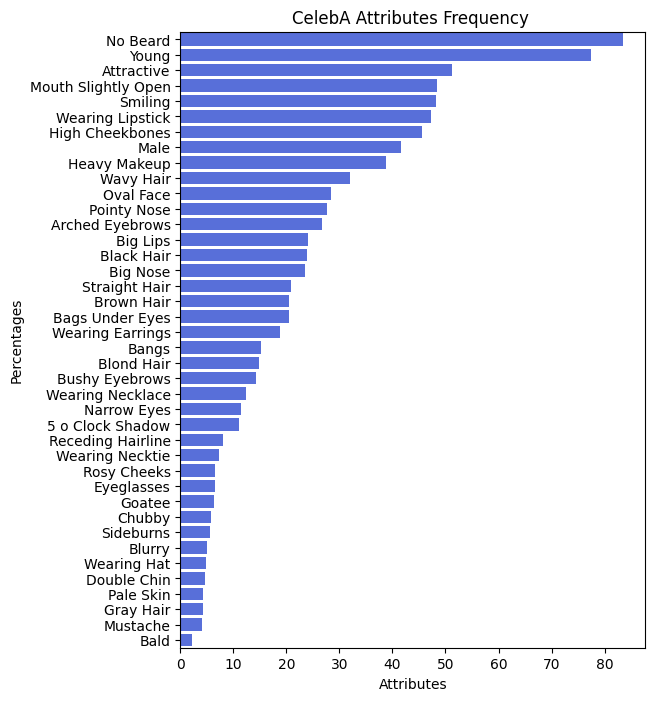

In [25]:
celeb_attr = celeb_attr.replace(to_replace=-1, value=0)

attr_counts = celeb_attr.loc[:, celeb_attr.columns != "image_id"].sum()
perc = (attr_counts / celeb_attr.shape[0]) * 100

percent_sorted = perc.sort_values(ascending=False)

plt.figure(figsize=(6, 8))
sns.barplot(x=percent_sorted.values, y=percent_sorted.index, color='#4361EE')
plt.title('CelebA Attributes Frequency ')
plt.xlabel('Attributes')
plt.ylabel('Percentages')
plt.show()

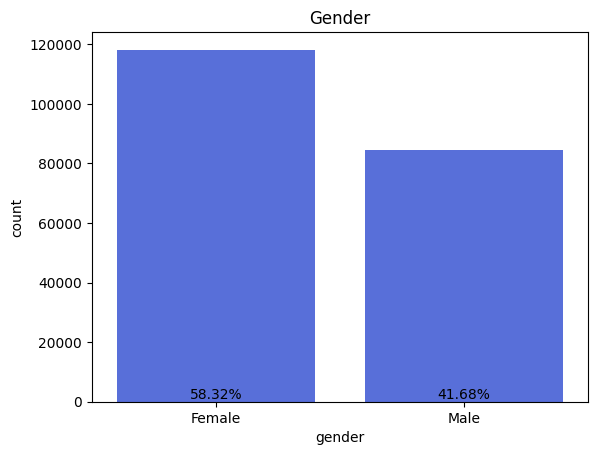

In [26]:
# Focusing only on Gender
gender_attr = celeb_attr['Male']
gender_attr = gender_attr.to_frame()

gender_attr.columns = ['gender']
gender_attr = gender_attr.replace(to_replace=1, value='Male')
gender_attr = gender_attr.replace(to_replace=0, value='Female')
male_perc = ((gender_attr['gender'] == 'Male').sum() / gender_attr.shape[0]) * 100
female_perc = ((gender_attr['gender'] == 'Female').sum() / gender_attr.shape[0]) * 100

plt.title('Gender')
sns.countplot(x='gender', data=gender_attr, color="#4361EE")
plt.text(1, male_perc, f'{male_perc:.2f}%', ha='center', va='bottom')
plt.text(0, female_perc, f'{female_perc:.2f}%', ha='center', va='bottom')
plt.show()

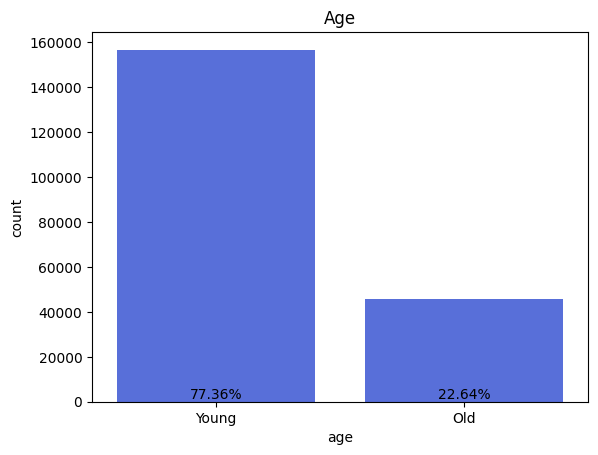

In [27]:
# Focusing only on Age
age_attr = celeb_attr['Young']
age_attr = age_attr.to_frame()

age_attr.columns = ['age']
age_attr = age_attr.replace(to_replace=1, value='Young')
age_attr = age_attr.replace(to_replace=0, value='Old')
young_perc = ((age_attr['age'] == 'Young').sum() / age_attr.shape[0]) * 100
old_perc = ((age_attr['age'] == 'Old').sum() / age_attr.shape[0]) * 100

plt.title('Age')
sns.countplot(x='age', data=age_attr, color="#4361EE")
plt.text(0, young_perc, f'{young_perc:.2f}%', ha='center', va='bottom')
plt.text(1, old_perc, f'{old_perc:.2f}%', ha='center', va='bottom')
plt.show()

In [28]:
def plotCorrelationMatrix(df, graphWidth):
    df = df[[col for col in df if df[col].nunique() > 1]]
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.show()

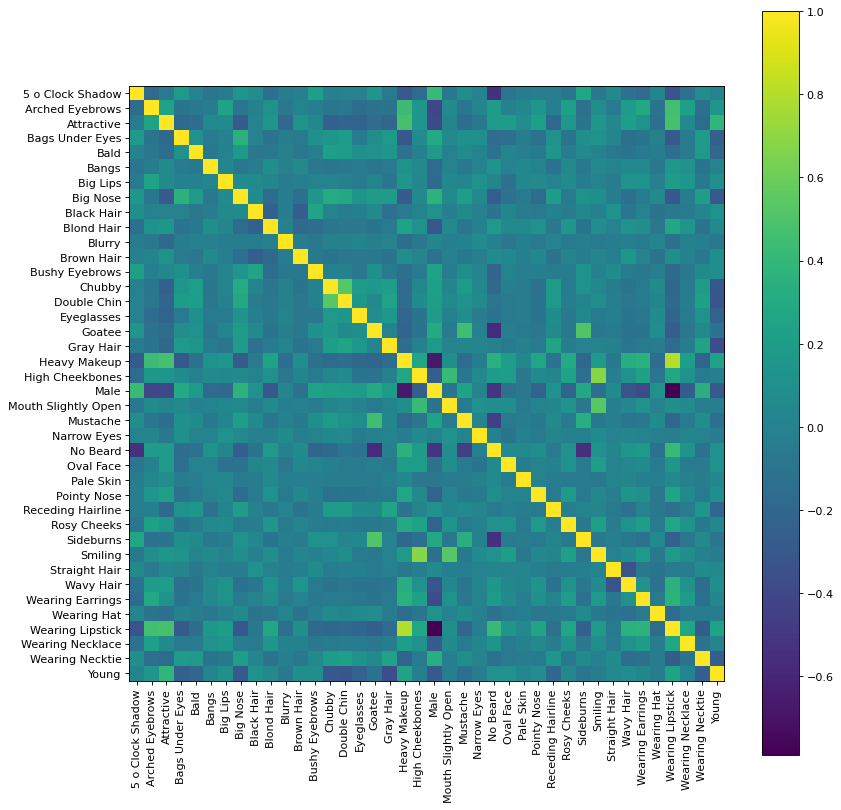

In [29]:
# correlation Matrix
plotCorrelationMatrix(celeb_attr.loc[:, celeb_attr.columns != 'image_id'], 12)

We can identify that we can group some of the features into one single and and encode those as per each feature.

Dimensionality Reduction

PS: Is it necessary?

In [30]:
# def hair_color(df):
#   if df["Blond_Hair"] == 1:
#     return 0
#   elif df["Brown_Hair"] == 1:
#     return 1
#   elif df["Black_Hair"] == 1:
#     return 2
#   elif df["Gray_Hair"] == 1:
#     return 3
#   else:
#     return 4

# def hair_type(df):
#   if df["Straight_Hair"] == 1:
#     return 0
#   elif df["Wavy_Hair"] == 1:
#     return 1
#   else :
#     return 2

# def wearing_style(df):
#   if df["Wearing_Earrings"] == 1:
#     return 0
#   elif df["Wearing_Hat"] == 1:
#     return 1
#   elif df["Wearing_Lipstick"] == 1:
#     return 2
#   elif df["Wearing_Necklace"] == 1:
#     return 3
#   elif df["Wearing_Necktie"] == 1:
#     return 4
#   else :
#     return 5

In [31]:
# celeb_attr["Hair_Color"] = celeb_attr.apply(hair_color, axis=1)
# celeb_attr["Hair_Type"] = celeb_attr.apply(hair_type, axis=1)
# celeb_attr["Wearing_style"] = celeb_attr.apply(wearing_style, axis=1)

# celeb_attr.drop(columns=["Blond_Hair", "Brown_Hair", "Black_Hair", "Gray_Hair", "Straight_Hair", "Wavy_Hair", "Wearing_Earrings", "Wearing_Hat", "Wearing_Lipstick", "Wearing_Necklace", "Wearing_Necktie"], axis = 1, inplace=True)

In [32]:
# celeb_attr.columns

In [33]:
# # correlation Matrix
# plotCorrelationMatrix(celeb_attr.loc[:, celeb_attr.columns != 'image_id'], 12)

### **Modeling and Evaluation**

In [34]:
# Reading evaluation parameters and labels
eval_imgs = eval_partition['image_id'].values
eval_val = eval_partition['partition'].values
labels = celeb_attr.loc[:, celeb_attr.columns != 'image_id'].values

eval_pars = dict(eval_partition['partition'].value_counts())
print(eval_pars)
# 0 - train
# 1 - validation
# 2 - test

train_idx = eval_pars[0]
val_idx = eval_pars[1]
test_idx = eval_pars[2]

{0: 162770, 2: 19962, 1: 19867}


In [35]:
# Taking only 40000 data train right now and 5000 data for validation and testing
train_st = 0
train_en = train_st + 29500
val_st = train_idx + 1
val_en = val_st + 4000
test_st = train_idx + val_idx + 1
test_en = test_st + 4000

In [36]:
def create_folders_and_paths(start_index, end_index, folder_prefix):
    idx = 1
    imgs = []
    label = []
    for i in range(start_index, end_index, 10000):
        folder_path = os.path.join(celeb_imgs_file, f"{folder_prefix}_{idx}", )
        if end_index - i >= 10000:
            img_paths = list(map(lambda name: os.path.join(folder_path, name), eval_imgs[i:i+9999]))
            imgs.extend(img_paths)
            label.extend(labels[i:i+9999])
        else:
            img_paths = list(map(lambda name: os.path.join(folder_path, name), eval_imgs[i:end_index]))
            imgs.extend(img_paths)
            label.extend(labels[i:end_index])
        idx += 1
    return imgs, label

train_imgs, train_labels = create_folders_and_paths(train_st, train_en, 'train')
validation_imgs, validation_labels = create_folders_and_paths(val_st, val_en, 'validation')
test_imgs, test_labels = create_folders_and_paths(test_st, test_en, 'test')

print(len(train_imgs))
print(len(train_labels))

29498
29498


In [37]:
# creating transformations that needs to be applied on the training, validation, testing data respectively
train_transform = transforms.Compose([transforms.Resize((64, 64)),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.ToTensor(),
                                      # the mean ans std are  derived from the ImageNet dataset, which is often used for pre-training deep learning models
                                      transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

validation_transform = transforms.Compose([transforms.Resize((64, 64)),
                                           transforms.RandomHorizontalFlip(p=0.75),
                                           transforms.ToTensor(),
                                           # the mean ans std are  derived from the ImageNet dataset, which is often used for pre-training deep learning models
                                           transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

test_transform = transforms.Compose([transforms.Resize((64, 64)),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     # the mean ans std are  derived from the ImageNet dataset, which is often used for pre-training deep learning models
                                     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

In [38]:
# getting classes and reading images and it's corresponding labels or classes
def get_class(celeb_attr):
  classes = celeb_attr.loc[:, celeb_attr.columns != 'image_id'].columns.to_list()
  return classes

def celeb_dataset(img_paths, labels, transform=None):
  img_and_labels = [(img_path, label) for img_path, label in zip(img_paths, labels)]
  img_dataset = []
  cnt = 0
  print("process started!")
  for img_path, label in img_and_labels:
      image = PILImage.open(img_path).convert('RGB')
      if transform:
          image = transform(image)
      img_dataset.append({'image': image, 'label': torch.Tensor(label)})
      cnt = cnt + 1
      if cnt % 500 == 0:
        print(f"Passed {cnt} images")
  return img_dataset

In [39]:
print(torch.cuda.is_available()) # where cuda can be used
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

True
cuda


In [40]:
class GetCelebDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform
        self.classes = get_class(celeb_attr)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = PILImage.open(self.data[idx]).convert('RGB')
        label = torch.Tensor(self.labels[idx])
        if self.transform:
            image = self.transform(image)
            sample = {'image': image, 'label': label}
        else:
            sample = {'image': image, 'label': label}
        return sample

In [41]:
train_dataset = GetCelebDataset(train_imgs, train_labels, train_transform)
val_dataset = GetCelebDataset(validation_imgs, validation_labels, validation_transform)
test_dataset = GetCelebDataset(test_imgs, test_labels, test_transform)

In [42]:
# Training data statistics

print(f"Total number of training images in the dataset: {len(train_dataset)}")
print(f"Shape of a sample image: {train_dataset[0]['image'].shape}")
print(f"Shape of a sample image is {train_dataset[15]['image'].shape} and it's class value is {train_dataset[15]['label']}")
print(f"List of the classes: {train_dataset.classes}")

Total number of training images in the dataset: 29498
Shape of a sample image: torch.Size([3, 64, 64])
Shape of a sample image is torch.Size([3, 64, 64]) and it's class value is tensor([1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 1.])
List of the classes: ['5 o Clock Shadow', 'Arched Eyebrows', 'Attractive', 'Bags Under Eyes', 'Bald', 'Bangs', 'Big Lips', 'Big Nose', 'Black Hair', 'Blond Hair', 'Blurry', 'Brown Hair', 'Bushy Eyebrows', 'Chubby', 'Double Chin', 'Eyeglasses', 'Goatee', 'Gray Hair', 'Heavy Makeup', 'High Cheekbones', 'Male', 'Mouth Slightly Open', 'Mustache', 'Narrow Eyes', 'No Beard', 'Oval Face', 'Pale Skin', 'Pointy Nose', 'Receding Hairline', 'Rosy Cheeks', 'Sideburns', 'Smiling', 'Straight Hair', 'Wavy Hair', 'Wearing Earrings', 'Wearing Hat', 'Wearing Lipstick', 'Wearing Necklace', 'Wearing Necktie', 'Young']


In [43]:
# Validation data statistics

print(f"Total number of validation images in the dataset: {len(val_dataset)}")
print(f"Shape of a sample image: {val_dataset[10]['image'].shape}")
print(f"Shape of a sample image is {val_dataset[30]['image'].shape} and it's class value is {val_dataset[30]['label']}")
print(f"List of the classes: {val_dataset.classes}")

Total number of validation images in the dataset: 4000
Shape of a sample image: torch.Size([3, 64, 64])
Shape of a sample image is torch.Size([3, 64, 64]) and it's class value is tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
        0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 1.])
List of the classes: ['5 o Clock Shadow', 'Arched Eyebrows', 'Attractive', 'Bags Under Eyes', 'Bald', 'Bangs', 'Big Lips', 'Big Nose', 'Black Hair', 'Blond Hair', 'Blurry', 'Brown Hair', 'Bushy Eyebrows', 'Chubby', 'Double Chin', 'Eyeglasses', 'Goatee', 'Gray Hair', 'Heavy Makeup', 'High Cheekbones', 'Male', 'Mouth Slightly Open', 'Mustache', 'Narrow Eyes', 'No Beard', 'Oval Face', 'Pale Skin', 'Pointy Nose', 'Receding Hairline', 'Rosy Cheeks', 'Sideburns', 'Smiling', 'Straight Hair', 'Wavy Hair', 'Wearing Earrings', 'Wearing Hat', 'Wearing Lipstick', 'Wearing Necklace', 'Wearing Necktie', 'Young']


In [44]:
# Testing data statistics

print(f"Total number of tesitng images in the dataset: {len(test_dataset)}")
print(f"Shape of a sample image: {test_dataset[10]['image'].shape}")
print(f"Shape of a sample image is {test_dataset[35]['image'].shape} and it's class value is {test_dataset[35]['label']}")
print(f"List of the classes: {test_dataset.classes}")

Total number of tesitng images in the dataset: 4000
Shape of a sample image: torch.Size([3, 64, 64])
Shape of a sample image is torch.Size([3, 64, 64]) and it's class value is tensor([0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 1., 1.])
List of the classes: ['5 o Clock Shadow', 'Arched Eyebrows', 'Attractive', 'Bags Under Eyes', 'Bald', 'Bangs', 'Big Lips', 'Big Nose', 'Black Hair', 'Blond Hair', 'Blurry', 'Brown Hair', 'Bushy Eyebrows', 'Chubby', 'Double Chin', 'Eyeglasses', 'Goatee', 'Gray Hair', 'Heavy Makeup', 'High Cheekbones', 'Male', 'Mouth Slightly Open', 'Mustache', 'Narrow Eyes', 'No Beard', 'Oval Face', 'Pale Skin', 'Pointy Nose', 'Receding Hairline', 'Rosy Cheeks', 'Sideburns', 'Smiling', 'Straight Hair', 'Wavy Hair', 'Wearing Earrings', 'Wearing Hat', 'Wearing Lipstick', 'Wearing Necklace', 'Wearing Necktie', 'Young']


In [45]:
def dataloader(batch_size, device):
    num_workers = 0 if device.type == 'cuda' else 1
    pin_memory = device.type == 'cuda'

    classes = train_dataset.classes

    train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory,shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, shuffle=False)

    return train_loader, val_loader, test_loader

In [46]:
def generate_class_weights(class_series, class_labels):
    n_samples = len(class_series)
    n_classes = len(class_series[0])

    class_count = [0] * n_classes
    for classes in class_series:
        for index in range(n_classes):
            if classes[index] != 0:
                class_count[index] += 1

    class_weights = [n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count]
    class_labels = range(len(class_weights))
    return dict(zip(class_labels, class_weights))

In [47]:
class_weights = generate_class_weights(train_labels, train_dataset.classes)
class_weights

{0: 0.22192296117965693,
 1: 0.09492212639979405,
 2: 0.048705501618122975,
 3: 0.12266300731869594,
 4: 1.094139465875371,
 5: 0.16409657320872273,
 6: 0.10496014802163393,
 7: 0.10522973744292237,
 8: 0.1036035403203147,
 9: 0.17011534025374855,
 10: 0.4694143857415659,
 11: 0.12239834024896265,
 12: 0.17479260488267362,
 13: 0.43456098998232173,
 14: 0.5402564102564102,
 15: 0.3865041928721174,
 16: 0.39541554959785524,
 17: 0.5932823813354787,
 18: 0.06532465231641421,
 19: 0.05565240359218172,
 20: 0.05920439948619139,
 21: 0.05248380898156715,
 22: 0.6125,
 23: 0.2123380362798733,
 24: 0.03004359162388984,
 25: 0.08942039529525889,
 26: 0.5681432973805856,
 27: 0.09068494835218888,
 28: 0.3166380420781451,
 29: 0.3960526315789474,
 30: 0.43507374631268436,
 31: 0.052607361963190186,
 32: 0.11890519187358917,
 33: 0.07891385767790263,
 34: 0.1347925424968013,
 35: 0.5171458625525946,
 36: 0.05347327967515046,
 37: 0.20790809134479843,
 38: 0.33444444444444443,
 39: 0.0320741997216

##### **Defining the model**

In [48]:
def accuracy_score(y_true, y_pred):
    num_samples = len(y_true)
    total_correct = 0
    total_labels = 0

    for true_labels, pred_labels in zip(y_true, y_pred):
        correct_labels = (true_labels == pred_labels).sum()
        total_correct += correct_labels
        total_labels += len(true_labels)

    accuracy = total_correct / total_labels
    return accuracy

def get_multilabel_evaluation(model, test_loader):
    all_predictions = []
    all_targets = []
    model.eval()
    with torch.no_grad():
        for dir_ in test_loader:
            inputs, targets = dir_.values()
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            predictions = (outputs > 0.01).float()
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())
    return all_predictions, all_targets

In [49]:
def train_model(model, device, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    train_losses = []
    train_accuracy_scores = []
    val_losses = []
    val_accuracy_scores = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        total_train_loss = 0

        train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch')
        for dict_ in train_bar:
            inputs, labels = dict_.values()
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            predicted_labels = (outputs > 0.5).float()
            accuracy_score_value = accuracy_score(labels.cpu().numpy(), predicted_labels.cpu().numpy())
            train_bar.set_postfix(loss=loss.item(), accuracy_score=accuracy_score_value)

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        train_accuracy_scores.append(accuracy_score_value)

        model.eval()
        total_val_loss = 0

        with torch.no_grad():
            for dict_ in val_loader:
                inputs, labels = dict_.values()
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item() * inputs.size(0)

                predicted_labels = (outputs > 0.5).float()
                val_accuracy_score = accuracy_score(labels.cpu().numpy(), predicted_labels.cpu().numpy())

        val_loss = total_val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracy_scores.append(val_accuracy_score)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train accuracy Score: {accuracy_score_value:.4f}, Val Loss: {val_loss:.4f}, Val accuracy Score: {val_accuracy_score:.4f}")

    return [train_losses, train_accuracy_scores, val_losses, val_accuracy_scores]

In [50]:
def define_model(train_loader, val_loader, test_loader, learning_rate, num_features, dropout_prob, device):

    Model = resnet50(weights=ResNet50_Weights.DEFAULT)

    Model.fc = nn.Sequential(
        nn.Linear(Model.fc.in_features, num_features),
        nn.ReLU(inplace=True),
        nn.Dropout(dropout_prob),
        nn.Linear(num_features, len(train_dataset.classes))
    )

    Model = Model.to(device)

    weight_tensor = torch.tensor(list(class_weights.values()), dtype=torch.float).to(device)
    criterion = nn.BCEWithLogitsLoss(weight=weight_tensor)

    optimizer = optim.Adam(Model.parameters(), lr=learning_rate)
    Metric = train_and_evaluate(Model, device, train_loader, val_loader, test_loader, criterion, optimizer)

    return Model, Metric

def train_and_evaluate(model, device, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs=8):
    Metric = []

    Metric.append(train_model(model, device, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs))

    true, pred = get_multilabel_evaluation(model, test_loader)
    predictions_np = np.concatenate(pred)
    targets_np = np.concatenate(true)
    precision, recall, f_score, _ = precision_recall_fscore_support(targets_np, predictions_np, average='weighted')
    Metric.append([precision, recall, f_score])

    return Metric

In [55]:
Model = resnet50(weights=ResNet50_Weights.DEFAULT)
Model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [51]:
parameters = {
    'batch_size': [64],
    'learning_rate': [0.01, 0.005, 0.001],
    'num_features': [512],
    'drop_out': [0.3, 0.5]
}

In [10]:
Metric = {}

def create_model_name(batch_size, learning_rate, num_features, drop_out):
    return f'models_trained/resnet50/attr_classification_{batch_size}_{learning_rate}_{num_features}_{drop_out}.pth'

def print_model_info(batch_size, learning_rate, num_features, drop_out):
    print(f'Model: | batch_size = {batch_size} learning_rate = {learning_rate}, num_features = {num_features}, drop_out = {drop_out} |')

for batch_size, learning_rate, num_features, drop_out in itertools.product(parameters['batch_size'], parameters['learning_rate'], parameters['num_features'], parameters['drop_out']):
    train_loader, val_loader, test_loader = dataloader(batch_size, device)
    model_name = create_model_name(batch_size, learning_rate, num_features, drop_out)
    print_model_info(batch_size, learning_rate, num_features, drop_out)
    print(f'=============================================================================')
    Model, Metric[model_name] = define_model(train_loader, val_loader, test_loader, learning_rate, num_features, drop_out, device)
    torch.save(Model.state_dict(), model_name)


NameError: name 'parameters' is not defined

In [52]:
def model_load(num_features, dropout_prob, device, name):
    Model = resnet50(weights=ResNet50_Weights.DEFAULT)
    Model.fc = nn.Sequential(
        nn.Linear(Model.fc.in_features, num_features),
        nn.ReLU(inplace=True),
        nn.Dropout(dropout_prob),
        nn.Linear(num_features, 40)
    )
    Model = Model.to(device)
    Model.load_state_dict(torch.load(name))
    return Model

Model = model_load(512, 0.5, device, 'models_trained/resnet50/attr_classification_64_0.001_512_0.3.pth')

In [53]:
def predict(image_path):
    Model.eval()
    image = PILImage.open(image_path).convert("RGB")
    image_tensor = test_transform(image)
    image_tensor = image_tensor.unsqueeze(0)
    image_tensor = image_tensor.to(device)
    with torch.no_grad():
        output = Model(image_tensor)
    probabilities = F.softmax(output, dim=1)
    predicted_classes = torch.zeros_like(probabilities, dtype=torch.int)
    # print(predicted_classes)
    threshold = 0.02
    predicted_classes[probabilities >= threshold] = 1
    predicted = predicted_classes[0].cpu().tolist()
    plt.imshow(image)
    plt.axis('off')  # Turn off axis
    plt.show()
    for ind in range(40):
        if predicted[ind] == 1:
            print(f"---> {train_dataset.classes[ind]} <---")

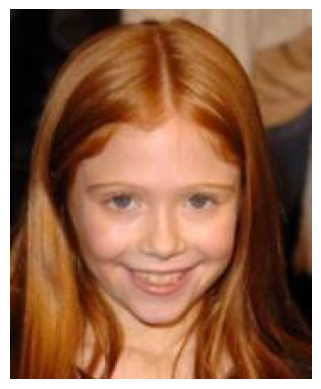

---> No Beard <---
---> Smiling <---


In [54]:
predict(r"extracted_images/test_1/182640.jpg")

In [55]:
def plot_evaluation(train_losses, train_accuracy_scores, val_losses, val_accuracy_scores, precision, recall, f_score):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot Losses
    axes[0].plot(train_losses, label='Train Losses', marker='o')
    axes[0].plot(val_losses, label='Validation Losses', marker='o')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Train and Validation Losses vs. Epochs')
    axes[0].legend()
    axes[0].grid(True)

    # Plot accuracy Scores
    axes[1].plot(train_accuracy_scores, label='Train accuracy Scores', marker='o')
    axes[1].plot(val_accuracy_scores, label='Validation accuracy Scores', marker='o')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy Score')
    axes[1].set_title('Train and Validation accuracy Scores')
    axes[1].legend()
    axes[1].grid(True)

    # Plot Precision, Recall, F-Score
    metrics = ['Precision', 'Recall', 'F-Score']
    values = [precision, recall, f_score]
    axes[2].bar(metrics, values, color=['blue', 'green', 'red'])
    axes[2].set_title('Score')
    axes[2].set_ylabel('Score')
    axes[2].grid(axis='y')
    axes[2].set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

In [56]:
file_path = "./model_evaluation/data_resnet.json"

with open(file_path, "w") as json_file:
    json.dump(Metric, json_file)

print("Data saved to", file_path)

Data saved to ./model_evaluation/data_resnet.json


In [57]:
with open('./model_evaluation/data_resnet.json', 'r') as file:
    data = json.load(file)

name_models = list(data.keys())

for name_ in name_models:
    parts = name_.split('_')
    batch_size = parts[1]
    learning_rate = parts[2]
    num_features = parts[3]
    dropout = parts[4].replace('.pth','')
    print(f'batch Size = {batch_size} | learning Rate = {learning_rate} | num_features = {num_features} | drop out = {dropout}')
    print(f'=============================================================================')
    train_losses, train_accuracy_scores, val_losses, val_accuracy_scores = data[name_][0]
    precision, recall, f_score = data[name_][1]
    plot_evaluation(train_losses, train_accuracy_scores, val_losses, val_accuracy_scores, precision, recall, f_score)

In [58]:
#shutil.copy("example_model.pth", "./models_trained/")

In [59]:
def show_images(images):
    num_rows = 4
    num_cols = 16
    plt.figure(figsize=(40, 10))
    plt.subplots_adjust(wspace=0, hspace=0)
    for i in range(len(images)):
        plt.subplot(num_rows, num_cols, i + 1)
        if images[i].dtype == 'uint8':
             plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        else:
             plt.imshow(images[i])
        plt.axis('off')
    plt.show()

In [60]:
def get_activation_maps(model, input_image):
    activation_maps = []
    activations = []
    def hook(module, input, output):
        activations.append(output)
    hooks = []
    for layer in model.children():
        if isinstance(layer, nn.Conv2d):
            hooks.append(layer.register_forward_hook(hook))
    with torch.no_grad():
        _ = model(input_image)
    for activation in activations:
        activation_maps.append(activation.squeeze().cpu())
    for hook in hooks:
        hook.remove()
    return activation_maps

In [61]:
image = PILImage.open("extracted_images/test_1/182640.jpg").convert("RGB")
image_tensor = train_transform(image)
image_tensor = image_tensor.unsqueeze(0)
activation_maps = get_activation_maps(Model, image_tensor)
show_images(activation_maps[0])

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

### **Testing Accuracy**

In [64]:
train_loader, val_loader, test_loader = dataloader(64, device)
all_predictions, all_targets = get_multilabel_evaluation(Model, test_loader)

# Convert the lists of arrays into numpy arrays
all_predictions = np.vstack(all_predictions)
all_targets = np.vstack(all_targets)

# Compute the accuracy using the accuracy_score function
accuracy = accuracy_score(all_targets, all_predictions)

print("Testing Accuracy:", accuracy)

Testing Accuracy: 0.894425
